# Binary classifiers, parameter tuning and decision threshold experimentation

## Exploration

In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics
from sklearn.metrics import classification_report
from collections import Counter

In [2]:
train_df = pd.read_csv('agnews_train.csv')
test_df = pd.read_csv('agnews_test.csv')

In [7]:
train_df.head()

,text,label,label_int,science_int,sports_int,world_int,business_int
0,"John Souza, a volunteer with the Boone County ...",Business,3,0,0,0,1
1,Spain needs only to beat an under-strength Fre...,Sports,1,0,1,0,0
2,"PANAMA CITY, Panama -- When the United States ...",World,2,0,0,1,0
3,"Gilbert Arenas, Jarvis Hayes and Anthony Peele...",Sports,1,0,1,0,0
4,"MEMPHIS, Tenn. -- Kobe Bryant had his worst sh...",Sports,1,0,1,0,0


In [5]:
train_df.describe()

,label_int,science_int,sports_int,world_int,business_int
count,109999.000000,109999.000000,109999.000000,109999.000000,109999.000000
mean,1.500341,0.249657,0.250384,0.249920,0.250039
std,1.117767,0.432816,0.433236,0.432969,0.433037
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000,0.000000,1.000000
max,3.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
test_df.head()

,text,label,label_int,science_int,sports_int,world_int,business_int
0,It #39;s over. Our relationship just hasn #39;...,Science,0,1,0,0,0
1,Toshiba Corp. announced Tuesday a 80 gigabyte ...,Science,0,1,0,0,0
2,Scientists go back to the drawing board in the...,Science,0,1,0,0,0
3,The first shuttle flight since the Columbia tr...,Science,0,1,0,0,0
4,"NEW YORK, Sept 21: Iraqi Prime Minister Iyad A...",World,2,0,0,1,0


In [6]:
test_df.describe()

,label_int,science_int,sports_int,world_int,business_int
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.496400,0.25370,0.245800,0.250900,0.249600
std,1.121032,0.43515,0.430582,0.433553,0.432803
min,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000
50%,2.000000,0.00000,0.000000,0.000000,0.000000
75%,2.000000,1.00000,0.000000,1.000000,0.000000
max,3.000000,1.00000,1.000000,1.000000,1.000000


We have an almost perfectly balanced dataset, and the distribution is similar accross training and testing set.

## First models

In this section, we are going to train 4 binary calssifiers, one for each label, and see how they perform. Therefore, let's only keep the text_column and the corresponding label column for each of the four labels.

In [12]:
science_tr_df = train_df[['text', 'science_int']]
sports_tr_df = train_df[['text', 'sports_int']]
world_tr_df = train_df[['text', 'world_int']]
business_tr_df = train_df[['text', 'business_int']]

science_ts_df = test_df[['text', 'science_int']]
sports_ts_df = test_df[['text', 'sports_int']]
world_ts_df = test_df[['text', 'world_int']]
business_ts_df = test_df[['text', 'business_int']]

Let's start with comparing classifiers for the science articles, we are going to compare two different classifiers, a naive bayes classifier and an SDG-based classifier and compare both their performance

First, let's import the necessary functions

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

Then, let's concatenate the necessary steps in a pipeline

In [16]:
science_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

Train the first model

In [17]:
science_nb.fit(science_tr_df.text, science_tr_df.science_int)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

Predict the test data with the model in order to be able to perform evaluation

In [18]:
science_nb_prediction = science_nb.predict(science_ts_df.text)

Let's see how the model performs

In [19]:
print(classification_report(science_ts_df.science_int,
                           science_nb_prediction))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7463
           1       0.91      0.76      0.83      2537

    accuracy                           0.92     10000
   macro avg       0.92      0.87      0.89     10000
weighted avg       0.92      0.92      0.92     10000



The model is quite precise on both classes, however, the recall on the positive class is quite lower than the recall of the negative class, meaning the model still recognizes the negative class (news articles not related to sports) way better than the positive class (news articles related to sports).

Let's perform the same steps for an SDG-classifier and see if it performs better.

In [27]:
science_sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-6, random_state=42,
                          max_iter=100, tol=None))
])

science_sgd.fit(science_tr_df.text, science_tr_df.science_int)

science_sgd_prediction = science_sgd.predict(science_ts_df.text)

print(classification_report(science_ts_df.science_int,
                           science_sgd_prediction))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      7463
           1       0.87      0.86      0.86      2537

    accuracy                           0.93     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.93      0.93      0.93     10000



So, with the SDG classifier the recall in fact went up for the positive class went up by ten percentage points, but as a tradeoff the precision decreased by 4 percentage points.

Let's repeat the same steps for the other 3 categories

In [23]:
def make_sklearn_sgd():
    classifier = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                              alpha=1e-3, random_state=42,
                              max_iter=5, tol=None)),
    ])
    return classifier

In [22]:
def make_sklearn_naive_bayes():
    classifier = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])
    return classifier

In [29]:
sports_nb = make_sklearn_naive_bayes()
sports_sgd = make_sklearn_sgd()
world_nb = make_sklearn_naive_bayes()
world_sgd = make_sklearn_sgd()
business_nb = make_sklearn_naive_bayes()
business_sgd = make_sklearn_sgd()

In [30]:
sports_nb.fit(sports_tr_df.text, sports_tr_df.sports_int)
sports_sgd.fit(sports_tr_df.text, sports_tr_df.sports_int)
world_nb.fit(world_tr_df.text, world_tr_df.world_int)
world_sgd.fit(world_tr_df.text, world_tr_df.world_int)
business_nb.fit(business_tr_df.text, business_tr_df.business_int)
business_sgd.fit(business_tr_df.text, business_tr_df.business_int)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [32]:
sports_sgd_prediction = sports_sgd.predict(sports_ts_df.text)
sports_nb_prediction = sports_nb.predict(sports_ts_df.text)
world_sgd_prediction = world_sgd.predict(world_ts_df.text)
world_nb_prediction = world_nb.predict(world_ts_df.text)
business_sgd_prediction = business_sgd.predict(business_ts_df.text)
business_nb_prediction = business_nb.predict(business_ts_df.text)

In [34]:
print(classification_report(sports_ts_df.sports_int,
                           sports_nb_prediction))
print(classification_report(sports_ts_df.sports_int,
                           sports_sgd_prediction))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7542
           1       0.97      0.94      0.95      2458

    accuracy                           0.98     10000
   macro avg       0.97      0.96      0.97     10000
weighted avg       0.98      0.98      0.98     10000

              precision    recall  f1-score   support

           0       0.90      0.99      0.95      7542
           1       0.97      0.67      0.79      2458

    accuracy                           0.91     10000
   macro avg       0.94      0.83      0.87     10000
weighted avg       0.92      0.91      0.91     10000



Interestingly, for the sports articles the naive bayes classifier does a much better job in terms of recall for the positive class. (maybe dive into the models in order to understand why)

In [35]:
print(classification_report(world_ts_df.world_int,
                           world_nb_prediction))
print(classification_report(world_ts_df.world_int,
                           world_sgd_prediction))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      7491
           1       0.95      0.82      0.88      2509

    accuracy                           0.94     10000
   macro avg       0.94      0.90      0.92     10000
weighted avg       0.94      0.94      0.94     10000

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      7491
           1       0.98      0.50      0.66      2509

    accuracy                           0.87     10000
   macro avg       0.92      0.75      0.79     10000
weighted avg       0.89      0.87      0.85     10000



The same goes for the world articles, the naive bayes classifier does a much better job in terms of recall. Moreover, here the SGD-based classifier has a recall of 1, which may be a sign of overfitting.

In [36]:
print(classification_report(business_ts_df.business_int,
                           business_nb_prediction))
print(classification_report(business_ts_df.business_int,
                           business_sgd_prediction))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7504
           1       0.89      0.76      0.82      2496

    accuracy                           0.92     10000
   macro avg       0.91      0.87      0.88     10000
weighted avg       0.92      0.92      0.91     10000

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      7504
           1       0.92      0.43      0.59      2496

    accuracy                           0.85     10000
   macro avg       0.88      0.71      0.75     10000
weighted avg       0.86      0.85      0.83     10000



Finally, for the business articles, the naive bayes classifier also performs significantly better than the SGD-based classifier, especially on the recall.

## Model refinement and hyperparameter tuning

Let's try to fine tune our model parameters, more specifically by trying out bag of n-grams for various n. In order to experiment, let's move back to the first classifier for science articles.

In [37]:
from sklearn.model_selection import GridSearchCV

Without specifying the type of n-gram, the SGD-based classifier worked best in the previous section. So, let's experiment with this type of classifier.

In [38]:
sgd_science_grid_estimator = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42,max_iter=100, tol=None)),
])

sgd_grid_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': (1e-3, 1e-6, 1e-9, 1e-12)
}

sgd_science_grid= GridSearchCV(sgd_science_grid_estimator, sgd_grid_parameters, verbose=1)

In [39]:
sgd_science_grid.fit(science_tr_df.text, science_tr_df.science_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 22.4min finished


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(max_iter=100,
                                                      random_state=42,
                                                      tol=None))]),
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09, 1e-12),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

Let's have a look at the best parameters

In [41]:
sgd_science_grid.best_params_

{'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}

Ok now let's see how the best model performs against the model we trained in the previous section

In [42]:
sgd_science_best = sgd_science_grid.best_estimator_

In [43]:
print(classification_report(science_ts_df.science_int,
                           sgd_science_best.predict(science_ts_df.text)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7463
           1       0.89      0.88      0.88      2537

    accuracy                           0.94     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.94      0.94      0.94     10000



Ok, so we have a slight improvement of 2 percentage points on the precision for the positive class and of 2 percentage points on the recall for the positive class. That is interesting, but not astonishing. Let's try to improve the model further by optimizing the model taking in bigger bags of words and setting alpha to 1e-06, in order to reduce training time. Aditionally let's allow gridsearch to perform several jobs in parallel, to further reduce training time.

In [45]:
sgd_science_grid_estimator_2 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42,max_iter=100, tol=None, alpha = 1e-6)),
])

sgd_grid_parameters_2 = {
    'vect__ngram_range': [(1,3),(1,4),(1,5)]
}

sgd_science_grid_2 = GridSearchCV(sgd_science_grid_estimator_2, sgd_grid_parameters_2, verbose=1, n_jobs = 4)

In [46]:
sgd_science_grid_2.fit(science_tr_df.text, science_tr_df.science_int)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  7.8min finished


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(alpha=1e-06, max_iter=100,
                                                      random_state=42,
                                                      tol=None))]),
             n_jobs=4,
             param_grid={'vect__ngram_range': [(1, 3), (1, 4), (1, 5)]},
             verbose=1)

In [48]:
sgd_science_grid_2.best_params_

{'vect__ngram_range': (1, 4)}

In [50]:
sgd_science_best_2 = sgd_science_grid_2.best_estimator_

In [51]:
print(classification_report(science_ts_df.science_int,
                           sgd_science_best_2.predict(science_ts_df.text)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7463
           1       0.89      0.88      0.89      2537

    accuracy                           0.94     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.94      0.94      0.94     10000



Well, this didn't really improve the model performance compared to the one we trained with the 3-gram. Depending on the applications of the model, it would be nice to have a recall above 90% for the positive class. let's try to increase the recall of the model by modifying the decision threshold of the model. But before, let's have a look at the precision / recall curve of the model.

In [52]:
import matplotlib.pyplot as plt
import numpy as np

In [53]:
pr_sgd_science = sklearn.metrics.precision_recall_curve(science_ts_df.science_int, sgd_science_best_2.decision_function(science_ts_df.text),pos_label=1)


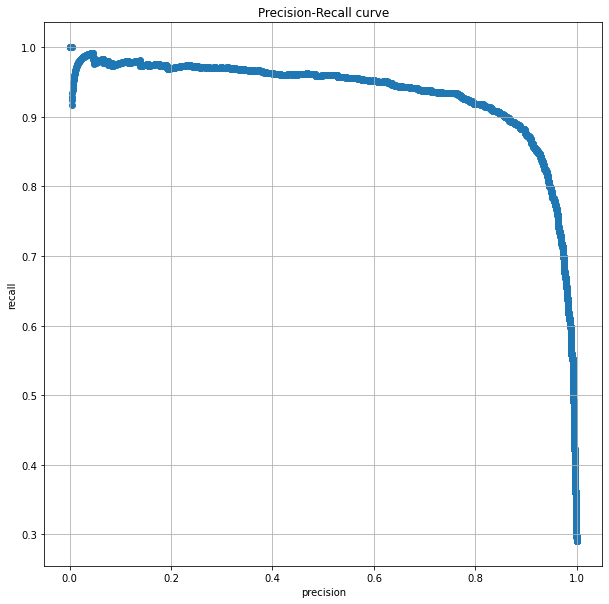

In [55]:
plt.figure(figsize=(10,10))
plt.title('Precision-Recall curve')
plt.xlabel('precision')
plt.ylabel('recall')
plt.scatter(y=pr_sgd_science[0], x=pr_sgd_science[1])
plt.grid(True)

That looks a bit unfortunate, it seems like if we push the threshold to have a recall of more than 90%, our precision drops below 90%. In practical terms this would mean that at least 9 science articles out of 10 are correctly labeled as science articles, but out of 10 articles labeled as science article, less than 9 would actually correspond to science articles.

Nevertheless, let's play a bit with the threshold in order to see how close we can get.

In [61]:
test_scores = sgd_science_best_2.decision_function(science_ts_df.text)

for threshold in [-1, -0.8, -0.5,-0.2, 0 ,0.2, 0.5, 0.8, 1]:
    print("Metrics with threshold={}".format(threshold))
    print(classification_report(science_ts_df.science_int,
                                [1 if s>threshold else 0 for s in test_scores],))
    print()

Metrics with threshold=-1
              precision    recall  f1-score   support

           0       0.99      0.77      0.87      7463
           1       0.60      0.99      0.75      2537

    accuracy                           0.83     10000
   macro avg       0.80      0.88      0.81     10000
weighted avg       0.89      0.83      0.84     10000


Metrics with threshold=-0.8
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7463
           1       0.70      0.97      0.81      2537

    accuracy                           0.89     10000
   macro avg       0.84      0.91      0.87     10000
weighted avg       0.92      0.89      0.89     10000


Metrics with threshold=-0.5
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7463
           1       0.80      0.95      0.87      2537

    accuracy                           0.93     10000
   macro avg       0.89      0.93      0.91 

The tradeoff between recall and accuracy remains, it is very hard to find an optimum.

Let's replicate the same steps for the 3 other classifiers, focusing on the naive bayes classifier since it performed best in the first place, and see how far we can push the performance.

In [65]:
nb_sports_grid_estimator = make_sklearn_naive_bayes()
nb_world_grid_estimator = make_sklearn_naive_bayes()
nb_business_grid_estimator = make_sklearn_naive_bayes()

nb_grid_parameters = {
    'vect__ngram_range': [(1, 2), (1,3),(1,4)],
    'clf__alpha': (1e-3, 1e-6, 1e-9)
}

nb_sports_grid= GridSearchCV(nb_sports_grid_estimator, nb_grid_parameters, verbose=1, n_jobs=5)
nb_world_grid= GridSearchCV(nb_world_grid_estimator, nb_grid_parameters, verbose=1, n_jobs=5)
nb_business_grid= GridSearchCV(nb_business_grid_estimator, nb_grid_parameters, verbose=1, n_jobs=5)

In [66]:
nb_sports_grid.fit(sports_tr_df.text, sports_tr_df.sports_int)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed: 12.7min finished


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=5,
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09),
                         'vect__ngram_range': [(1, 2), (1, 3), (1, 4)]},
             verbose=1)

In [67]:
nb_world_grid.fit(world_tr_df.text, world_tr_df.world_int)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed: 14.4min finished


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=5,
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09),
                         'vect__ngram_range': [(1, 2), (1, 3), (1, 4)]},
             verbose=1)

In [68]:
nb_business_grid.fit(business_tr_df.text, business_tr_df.business_int)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed: 11.9min finished


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=5,
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09),
                         'vect__ngram_range': [(1, 2), (1, 3), (1, 4)]},
             verbose=1)

In [70]:
nb_sports_best = nb_sports_grid.best_estimator_

In [73]:
print(nb_sports_grid.best_params_)

{'clf__alpha': 0.001, 'vect__ngram_range': (1, 2)}


In [72]:
print(classification_report(sports_ts_df.sports_int,
                           nb_sports_best.predict(sports_ts_df.text)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7542
           1       0.96      0.97      0.97      2458

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



That is a very good classifier, compared to the previous naive bayes classifier for sports articles, the recall for the positive class increased by 3 percentage points. Let's look at the precision / recall curve 

In [85]:
pr_nb_sports = sklearn.metrics.precision_recall_curve(sports_ts_df.sports_int, nb_sports_best.predict_proba(sports_ts_df.text)[:,1],pos_label=1)

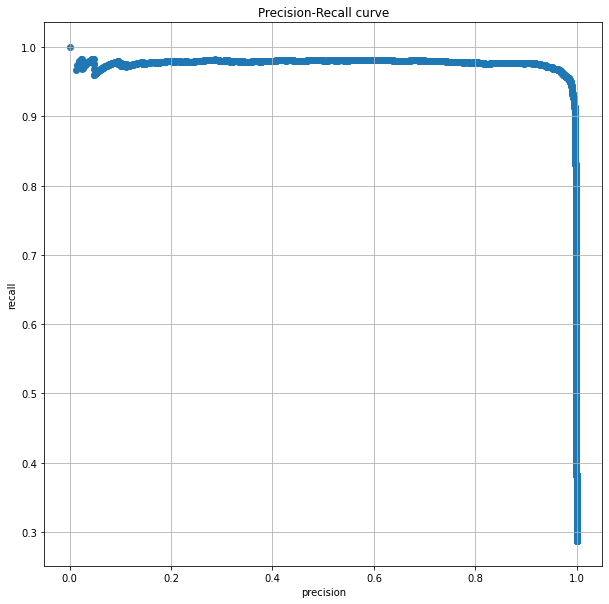

In [86]:
plt.figure(figsize=(10,10))
plt.title('Precision-Recall curve')
plt.xlabel('precision')
plt.ylabel('recall')
plt.scatter(y=pr_nb_sports[0], x=pr_nb_sports[1])
plt.grid(True)

Beautiful !!!

In [87]:
nb_world_best = nb_world_grid.best_estimator_

In [88]:
print(nb_world_grid.best_params_)

{'clf__alpha': 0.001, 'vect__ngram_range': (1, 2)}


In [89]:
print(classification_report(world_ts_df.world_int,
                           nb_world_best.predict(world_ts_df.text)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7491
           1       0.93      0.87      0.90      2509

    accuracy                           0.95     10000
   macro avg       0.94      0.92      0.93     10000
weighted avg       0.95      0.95      0.95     10000



Although the model is performing better than the model with single words, the recall is still below 90%, let's look at the precision / recall curve.

In [90]:
pr_nb_world = sklearn.metrics.precision_recall_curve(world_ts_df.world_int, nb_world_best.predict_proba(world_ts_df.text)[:,1],pos_label=1)

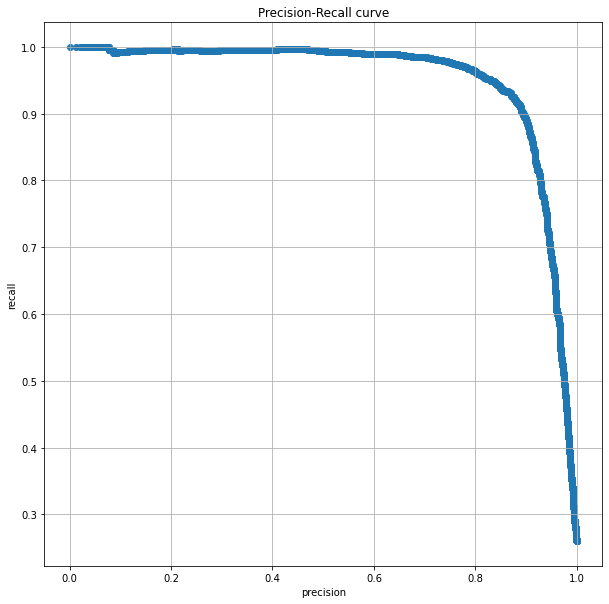

In [91]:
plt.figure(figsize=(10,10))
plt.title('Precision-Recall curve')
plt.xlabel('precision')
plt.ylabel('recall')
plt.scatter(y=pr_nb_world[0], x=pr_nb_world[1])
plt.grid(True)

It's a bit hard to tell from the graph but it seems that we can reach 90% recall without dropping below 90% precision. Let's try it.

In [99]:
test_scores_world_nb = nb_world_best.predict_proba(world_ts_df.text)[:,1]

for threshold in [0.1, 0.2, 0.3, 0.4]:
    print("Metrics with threshold={}".format(threshold))
    print(classification_report(world_ts_df.world_int,
                                [1 if s>threshold else 0 for s in test_scores_world_nb],))
    print()

Metrics with threshold=0.1
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7491
           1       0.89      0.90      0.90      2509

    accuracy                           0.95     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.95      0.95      0.95     10000


Metrics with threshold=0.2
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7491
           1       0.91      0.89      0.90      2509

    accuracy                           0.95     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.95      0.95      0.95     10000


Metrics with threshold=0.3
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7491
           1       0.92      0.88      0.90      2509

    accuracy                           0.95     10000
   macro avg       0.94      0.93      0.93  

It is really somewhere between a threshold of 0.1 and 0.2, let's try 0.14

In [102]:
print(classification_report(world_ts_df.world_int, [1 if s>0.14 else 0 for s in test_scores_world_nb]))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7491
           1       0.90      0.90      0.90      2509

    accuracy                           0.95     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.95      0.95      0.95     10000



It works, we have achieved a classifier with 90% precision and 90% recall for the positive class with this threshold.

In [103]:
nb_business_best = nb_business_grid.best_estimator_

In [104]:
print(nb_business_grid.best_params_)

{'clf__alpha': 0.001, 'vect__ngram_range': (1, 3)}


In [105]:
print(classification_report(business_ts_df.business_int,
                           nb_business_best.predict(business_ts_df.text)))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      7504
           1       0.88      0.84      0.86      2496

    accuracy                           0.93     10000
   macro avg       0.91      0.90      0.91     10000
weighted avg       0.93      0.93      0.93     10000



It also performs better than the model with simple bags of words, but here it is going to be hard to reach precision or recall above 90% without a major tradeoff. Let's look at the precision / recall curve.

In [106]:
pr_nb_business = sklearn.metrics.precision_recall_curve(business_ts_df.business_int, nb_business_best.predict_proba(business_ts_df.text)[:,1],pos_label=1)


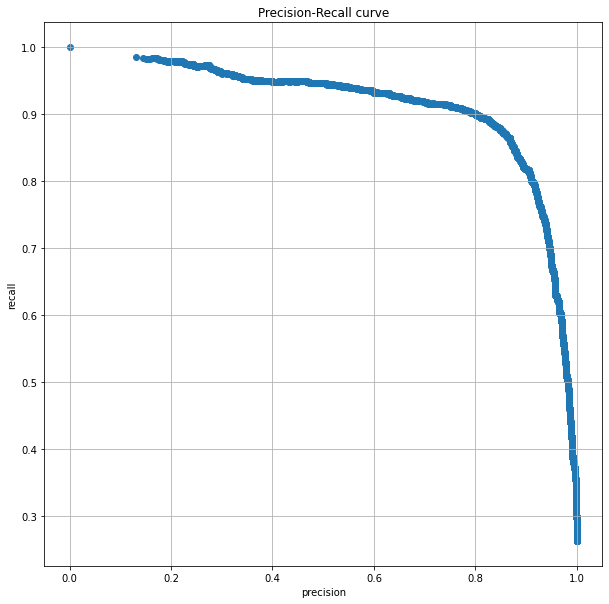

In [107]:
plt.figure(figsize=(10,10))
plt.title('Precision-Recall curve')
plt.xlabel('precision')
plt.ylabel('recall')
plt.scatter(y=pr_nb_business[0], x=pr_nb_business[1])
plt.grid(True)

As expected, the recall / precision tradeoff here is more important.